Basic Predictions
===============

This notebook tries to predict number of "confirmed cases" from patientdb available at http://api.covid19india.org/. 

Growth rate is computed as rate of change of confirmed cases and smoothened using a 7d rolling average.
It is extrapolated using the following methods:
* Quadartic curve fitting - fails to fit the curve correctly
* Hyperbolic curve fitting using a neural net - fits well and asymptotes the growth rate at ~7%.

The model is rudimentary and points towards a scenario where we fail to contain the epidemic and it eventually moves to stage 3/4.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter, DayLocator, AutoDateFormatter

import datetime as dt
import pandas as pd
import numpy as np
import requests

from sklearn.neural_network import MLPRegressor

In [2]:
resp = requests.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(int(d['dailyconfirmed']))
        r['deceased'].append(int(d['dailydeceased']))
        r['recovered'].append(int(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(data=r, index=r['date'], columns=['confirmed', 'deceased', 'recovered'])
df.sort_index(inplace=True)
df = df[31:][:] #drop Feb data
print("Records:", len(df))

Records: 81


,confirmed,deceased,recovered,total,growth,sma_growth
2020-05-16,4794,120,4012,90646,5.584028,5.370063
2020-05-17,5049,152,2538,95695,5.570020,5.186083
2020-05-18,4628,131,2482,100323,4.836198,5.113057
2020-05-19,6154,146,3032,106477,6.134187,5.270289
2020-05-20,5716,134,3113,112193,5.368296,5.321048


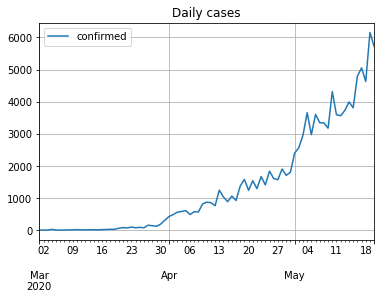

In [3]:
# cum sum
df['total'] = df['confirmed'].cumsum()

# calc growth rate & its moving avg
df['growth'] = 100 * df['confirmed'] / (df['total'] - df['confirmed'])
sma_gr = df['growth'].rolling(7).mean()
df['sma_growth'] = sma_gr

# daily plot
ax = df.plot(y='confirmed', kind='line', title="Daily cases", grid=True)
df.tail()

In [4]:
# create extrapolation dataframe
last_date = df.index[-1]
projections = pd.DataFrame(index=df.index.union(pd.date_range(start=last_date, periods=150, freq="1d")))

# fill with orig df
projections['confirmed'] = df['confirmed']
projections['total'] = df['total']
projections['sma_growth'] = df['sma_growth']
projections['day_of_yr'] = projections.index.dayofyear

# filter data for curve fitting (aka training data)
end_idx = len(df)
start_idx = end_idx - 35 # use 21 day sma data for curve fitting
fit_df = projections[start_idx:end_idx]
fit_df.tail()

,confirmed,total,sma_growth,day_of_yr
2020-05-16,4794.0,90646.0,5.370063,137
2020-05-17,5049.0,95695.0,5.186083,138
2020-05-18,4628.0,100323.0,5.113057,139
2020-05-19,6154.0,106477.0,5.270289,140
2020-05-20,5716.0,112193.0,5.321048,141


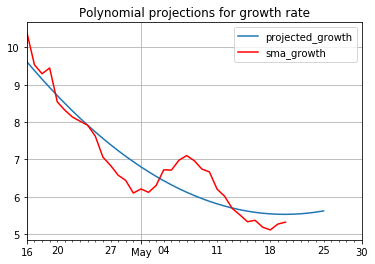

In [5]:
# fit polynomial curve
coeffs = np.polyfit(fit_df.day_of_yr, fit_df.sma_growth, 2) # 2nd degree
extrapolation_eqn = np.poly1d(coeffs)
projections['projected_growth'] = extrapolation_eqn(projections.day_of_yr)

# x axis ticks
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
mn_l = DayLocator()
       
ax = projections[start_idx:end_idx+5].plot(y='projected_growth', grid='True')
_ = projections[start_idx:end_idx+10].plot(y='sma_growth', color='red', grid=True, title="Polynomial projections for growth rate", ax=ax)

ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)

In [6]:
# train a neural network with hyperbolic activation function from day_of_yr => sma_growth
regressor = MLPRegressor(hidden_layer_sizes = (100,), activation = 'logistic', solver='lbfgs', max_iter=500)
# regressor = MLPRegressor(hidden_layer_sizes = (100,), activation = 'tanh', solver='lbfgs', max_iter=500)
_ = regressor.fit(X=fit_df[['day_of_yr']], y=fit_df['sma_growth'])

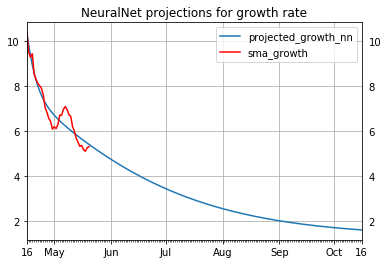

In [13]:
projections['projected_growth_nn'] = regressor.predict(X=projections[['day_of_yr']])
ax = projections[start_idx:end_idx+150].plot(
    y='projected_growth_nn', 
    grid=True
)
_ = projections[start_idx:end_idx+150].plot(
    y='sma_growth', 
    color='red', 
    title="NeuralNet projections for growth rate", 
    ax=ax, 
    grid=True
)

ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)
ax.tick_params(labeltop=False, labelright=True)



In [8]:
# compute total and daily numbers based on projected rate
prev_row_total = 0
def project(row):
    global prev_row_total
    if not np.isnan(row['total']):
        prev_row_total = row['total']
        return row['total']
    prev_row_total *= (1 + row['projected_growth_nn']/100)
    return prev_row_total

projections['projected_total'] = projections.apply(project, axis=1).astype('int64')

Date	 Projected Cases
May 31	 	 193477
June 30 	 642672
July 31 	 1599555


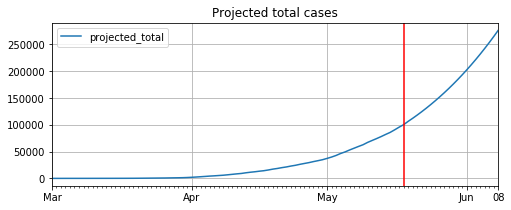

In [15]:
# plot 100 days from feb 1
ax = projections[0:100].plot(
    y='projected_total', 
    title="Projected total cases", 
    grid=True,
    figsize=(8,3)
)
ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)
ax.axvline(x=dt.datetime(day=18, month=5, year=2020), color='red')

#print("Projected death Count on ",projections.index[91].strftime("%B %d") , "is", projections['projected_total'][91])
print("Date\t Projected Cases")
print(projections.index[91].strftime("%B %d\t"),"\t", projections['projected_total'][91])
print(projections.index[121].strftime("%B %d"),"\t", projections['projected_total'][121])
print(projections.index[152].strftime("%B %d"),"\t", projections['projected_total'][152])
#projections[90:96]

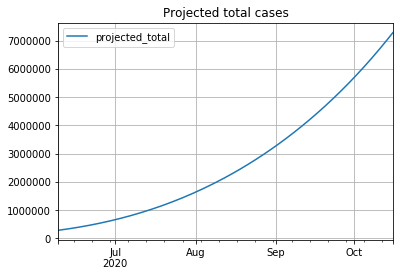

In [16]:
# plot next 100 days  
_ = projections[100:].plot(y='projected_total', title="Projected total cases", grid='True')

#projections[130:10]